#### 统计文献关键词

实现的功能：
- 关键词去重：通过nltk自然语言去重，也可以在synonym.csv文档中自行添加
- 提取占比高于1%的关键词（如果不足500个就按照500个计算），生成.csv文件
- 生成词云，柱状图，可以是图片格式(top 20)和html格式(top50)
- 可以指定最近n年或者全部


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings('ignore')
from pyecharts import options as opts
from pyecharts.charts import Bar, Pie, WordCloud as PyeWordCloud
from pyecharts.globals import ThemeType
import os
from datetime import datetime

In [30]:
# 下载nltk词库（如果首次使用）
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [31]:
# 读取CSV文件
def load_data(file_path):
    print("正在读取数据...")
    df = pd.read_csv(file_path)
    print(f"共读取{len(df)}条文献记录")
    return df

In [32]:
file_path = './scopus_files/CFpathPlanning101.csv'
save_path = './results'
df = load_data(file_path)

正在读取数据...
共读取101条文献记录


In [33]:
recent_year = None # 如果为None，则统计全部的年份，如果为n，则统计最近n年的
if recent_year:
    recent_year_content = 'Recent ' + str(recent_year) + ' years'
else:
    recent_year_content = 'All year'

In [34]:
base_filename = os.path.basename(file_path)
file_name_without_ext = os.path.splitext(base_filename)[0]
timestamp = datetime.now().strftime("%Y%m%d_%H")
output_dir = f"{save_path}/{file_name_without_ext}_{timestamp}"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"创建输出目录: {output_dir}")


In [35]:
# 提取并处理关键词
def extract_keywords(df, recent_years=None):
    print("正在提取关键词...")

    # 如果需要筛选最近几年的数据
    if recent_years is not None:
        # 获取当前年份
        current_year = datetime.now().year

        # 筛选最近n年的数据
        df = df[df['年份'].astype(int) >= (current_year - recent_years)]
        print(f"已筛选最近{recent_years}年的数据({current_year - recent_years}年至今)")

    # 合并作者关键字和索引关键字列
    keywords_columns = ['作者关键字', '索引关键字']
    all_keywords = []

    for column in keywords_columns:
        if column in df.columns:
            # 筛选非空值
            keywords = df[column].dropna().astype(str)
            # 分割关键词（通常以分号或逗号分隔）
            for kw_str in keywords:
                kws = re.split(r'[;,，；]', kw_str)
                all_keywords.extend([k.strip().lower() for k in kws if k.strip()])

    print(f"共提取出{len(all_keywords)}个关键词（含重复）")
    return all_keywords


In [36]:
all_keywords = extract_keywords(df,recent_year)

正在提取关键词...
共提取出1461个关键词（含重复）


In [37]:
# 构建同义词词典
def build_synonym_dict(keywords_list):
    print("正在构建同义词字典...")
    synonym_dict = {}

    # 构建关键词的小写形式映射到原始形式的字典（保持大小写）
    orig_case_dict = {}
    for kw in keywords_list:
        kw_lower = kw.lower()
        if kw_lower not in orig_case_dict or len(kw) < len(orig_case_dict[kw_lower]):
            orig_case_dict[kw_lower] = kw

    # 获取去重后的关键词列表（小写形式）
    unique_keywords = list(orig_case_dict.keys())

    # 构建同义词字典
    for i, kw1 in enumerate(unique_keywords):
        # 如果已经被合并了，就跳过
        if kw1 in synonym_dict:
            continue

        synsets1 = wordnet.synsets(kw1)

        # 将自己作为自己的同义词代表
        synonym_dict[kw1] = kw1

        # 检查是否是缩写词
        is_abbr1 = kw1.isupper() and len(kw1) <= 5

        for j in range(i+1, len(unique_keywords)):
            kw2 = unique_keywords[j]

            # 如果已经被合并了，就跳过
            if kw2 in synonym_dict and synonym_dict[kw2] != kw2:
                continue

            # 检查是否是缩写词
            is_abbr2 = kw2.isupper() and len(kw2) <= 5

            # 如果两个都是缩写词，暂时不合并
            if is_abbr1 and is_abbr2:
                continue

            # 字符串相似度检查（针对拼写变体和复数形式）
            if (kw1.startswith(kw2) or kw2.startswith(kw1) or
                kw1.endswith('s') and kw1[:-1] == kw2 or
                kw2.endswith('s') and kw2[:-1] == kw1):

                # 使用更长的形式作为代表
                if len(kw1) >= len(kw2):
                    synonym_dict[kw2] = kw1
                else:
                    synonym_dict[kw1] = kw2
                continue

            # WordNet同义词检查
            synsets2 = wordnet.synsets(kw2)

            if synsets1 and synsets2:
                # 检查是否有相同的同义词集
                if any(syn1 == syn2 for syn1 in synsets1 for syn2 in synsets2):
                    # 使用更常见的术语（在我们的数据集中出现次数更多的）
                    count1 = keywords_list.count(kw1)
                    count2 = keywords_list.count(kw2)

                    if count1 >= count2:
                        synonym_dict[kw2] = kw1
                    else:
                        synonym_dict[kw1] = kw2

    # 确保同义词链接到最终代表
    for kw in synonym_dict:
        target = synonym_dict[kw]
        while target != synonym_dict[target]:
            target = synonym_dict[target]
        synonym_dict[kw] = target

    # 转换为原始大小写形式
    for kw in list(synonym_dict.keys()):
        synonym_dict[kw] = orig_case_dict[synonym_dict[kw]]

    print(f"同义词字典构建完成，共有{len(set(synonym_dict.values()))}个唯一关键词")
    return synonym_dict

In [38]:
synonym_dict = build_synonym_dict(all_keywords)

正在构建同义词字典...
同义词字典构建完成，共有854个唯一关键词


In [39]:
# 根据同义词字典合并关键词
def merge_synonyms(keywords_list, synonym_dict=None, synonym_csv_path="synonym.csv"):
    print("正在合并同义词...")

    # 初始化同义词字典，如果传入了则使用
    if synonym_dict is None:
        synonym_dict = {}

    # 如果提供了CSV文件路径并且文件存在，则从CSV加载同义词
    if os.path.exists(synonym_csv_path):
        print(f"加载自定义同义词文件: {synonym_csv_path}")
        try:
            import pandas as pd
            custom_synonyms = pd.read_csv(synonym_csv_path)

            # 假设第一列是关键词变体，第二列是规范关键词
            for _, row in custom_synonyms.iterrows():
                variant = str(row.iloc[0]).lower()  # 第一列 - 变体/同义词(转小写)
                canonical = str(row.iloc[1])        # 第二列 - 规范词
                synonym_dict[variant] = canonical

            print(f"从CSV文件加载了 {len(custom_synonyms)} 个同义词映射")
        except Exception as e:
            print(f"加载同义词文件时出错: {e}")

    # 使用NLTK添加同义词（如果安装了nltk）
    try:
        from nltk.corpus import wordnet as wn
        for kw in keywords_list:
            synsets = wn.synsets(kw)
            if synsets:
                # 使用第一个同义词集的第一个词汇作为规范词
                lemma = synsets[0].lemmas()[0].name()
                synonym_dict[kw.lower()] = lemma
    except:
        print("NLTK wordnet未安装或无法使用，跳过NLTK同义词")

    # 将关键词列表中的单词替换为其在同义词字典中的标准形式
    merged_keywords = [synonym_dict.get(kw.lower(), kw) for kw in keywords_list]

    # 打印合并信息
    original_unique = len(set(keywords_list))
    merged_unique = len(set(merged_keywords))
    print(f"合并前独特关键词数量: {original_unique}")
    print(f"合并后独特关键词数量: {merged_unique}")
    print(f"减少了 {original_unique - merged_unique} 个重复关键词")

    return merged_keywords


In [40]:
merged_keywords = merge_synonyms(all_keywords, synonym_dict,"synonym.csv")

正在合并同义词...
加载自定义同义词文件: synonym.csv
从CSV文件加载了 33 个同义词映射
合并前独特关键词数量: 941
合并后独特关键词数量: 877
减少了 64 个重复关键词


In [41]:
def replace_keywords_in_document(df, synonym_dict, output_dir, file_name_without_ext):
    print("正在替换文档中的关键词...")

    # 创建df的副本，避免修改原始数据
    modified_df = df.copy()

    # 处理作者关键字和索引关键字列
    keywords_columns = ['作者关键字', '索引关键字']

    for column in keywords_columns:
        if column in modified_df.columns:
            # 定义替换函数
            def replace_keywords(kw_string):
                if pd.isna(kw_string):
                    return kw_string

                # 分割关键词
                keywords = re.split(r'[;,，；]', kw_string)
                replaced_keywords = []

                for kw in keywords:
                    kw = kw.strip()
                    if not kw:
                        continue

                    # 查找并替换同义词
                    kw_lower = kw.lower()
                    if kw_lower in synonym_dict:
                        replaced_keywords.append(synonym_dict[kw_lower])
                    else:
                        replaced_keywords.append(kw)

                # 使用分号重新连接关键词
                return '; '.join(replaced_keywords)

            # 应用替换函数到关键词列
            modified_df[column] = modified_df[column].apply(replace_keywords)

    # 统计修改数量
    total_changes = 0
    for column in keywords_columns:
        if column in modified_df.columns:
            changes = sum(modified_df[column] != df[column])
            total_changes += changes

    print(f"共修改了{total_changes}个关键词字段")

    # 保存修改后的文件，指定编码为utf-8-sig以支持中文和其他特殊字符
    output_file = f"{output_dir}/{file_name_without_ext}_replaced_synonyms.csv"
    modified_df.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"修改后的文件已保存至: {output_file}")

    return modified_df, output_file


In [42]:
# 调用函数替换关键词并保存文件
modified_df, replaced_file_path = replace_keywords_in_document(df, synonym_dict, output_dir, file_name_without_ext)

正在替换文档中的关键词...
共修改了200个关键词字段
修改后的文件已保存至: ./results/CFpathPlanning101_20250510_17/CFpathPlanning101_replaced_synonyms.csv


In [43]:
df = load_data(f"{output_dir}/{file_name_without_ext}_replaced_synonyms.csv")
all_keywords = extract_keywords(df,recent_year)


正在读取数据...
共读取101条文献记录
正在提取关键词...
共提取出1461个关键词（含重复）


In [44]:
# 统计关键词频率
def count_keywords(keywords_list):
    print("正在统计关键词频率...")
    counter = Counter(keywords_list)
    total = len(keywords_list)

    # 计算百分比并创建DataFrame
    keywords_df = pd.DataFrame({
        '关键词': list(counter.keys()),
        '频次': list(counter.values()),
        '百分比': [count/total*100 for count in counter.values()]
    })

    # 按频次降序排序
    keywords_df = keywords_df.sort_values('频次', ascending=False)

    print(f"共有{len(keywords_df)}个唯一关键词")
    return keywords_df

In [45]:
keywords_df = count_keywords(all_keywords)

正在统计关键词频率...
共有876个唯一关键词


In [46]:
# 筛选出占比1%以上的关键词，或者前500个关键词
def filter_keywords(keywords_df):
    print("正在筛选关键词...")
    # 筛选出占比1%以上的关键词
    filtered_df = keywords_df[keywords_df['百分比'] >= 1.0]

    # 如果占比1%以上的关键词少于500个，则取前500个
    if len(filtered_df) < 500:
        num_to_take = min(500, len(keywords_df))
        filtered_df = keywords_df.head(num_to_take)

    print(f"筛选后共有{len(filtered_df)}个关键词")
    return filtered_df

In [47]:
# 导出结果到CSV
def export_to_csv(df, filename):
    print(f"正在导出数据到{filename}...")
    df.to_csv(os.path.join(output_dir,recent_year_content+'_' +filename), index=False, encoding='utf-8-sig')
    print(f"数据已导出到{filename}")
    return filename


In [48]:
filtered_df = filter_keywords(keywords_df)
export_to_csv(filtered_df, 'filtered_keywords.csv')

正在筛选关键词...
筛选后共有500个关键词
正在导出数据到filtered_keywords.csv...
数据已导出到filtered_keywords.csv


'filtered_keywords.csv'

In [49]:
# 创建并保存词云图
def generate_wordcloud(keywords_df):
    print("正在生成词云图...")
    # 创建词频字典
    word_freq = dict(zip(keywords_df['关键词'], keywords_df['频次']))

    # 创建词云对象
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='white',
        max_words=200,
        colormap='viridis',
        contour_width=1,
        contour_color='steelblue'
    ).generate_from_frequencies(word_freq)

    # 显示词云图
    plt.figure(figsize=(16, 10), dpi=300)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(recent_year_content+' Word cloud of keywords from all literature', fontsize=20)
    plt.tight_layout()

    # 保存词云图
    plt.savefig(os.path.join(output_dir,recent_year_content+'_keywords_wordcloud.png'), bbox_inches='tight')
    print("词云图已保存为'keywords_wordcloud.png'")

    return wordcloud

正在生成词云图...
词云图已保存为'keywords_wordcloud.png'


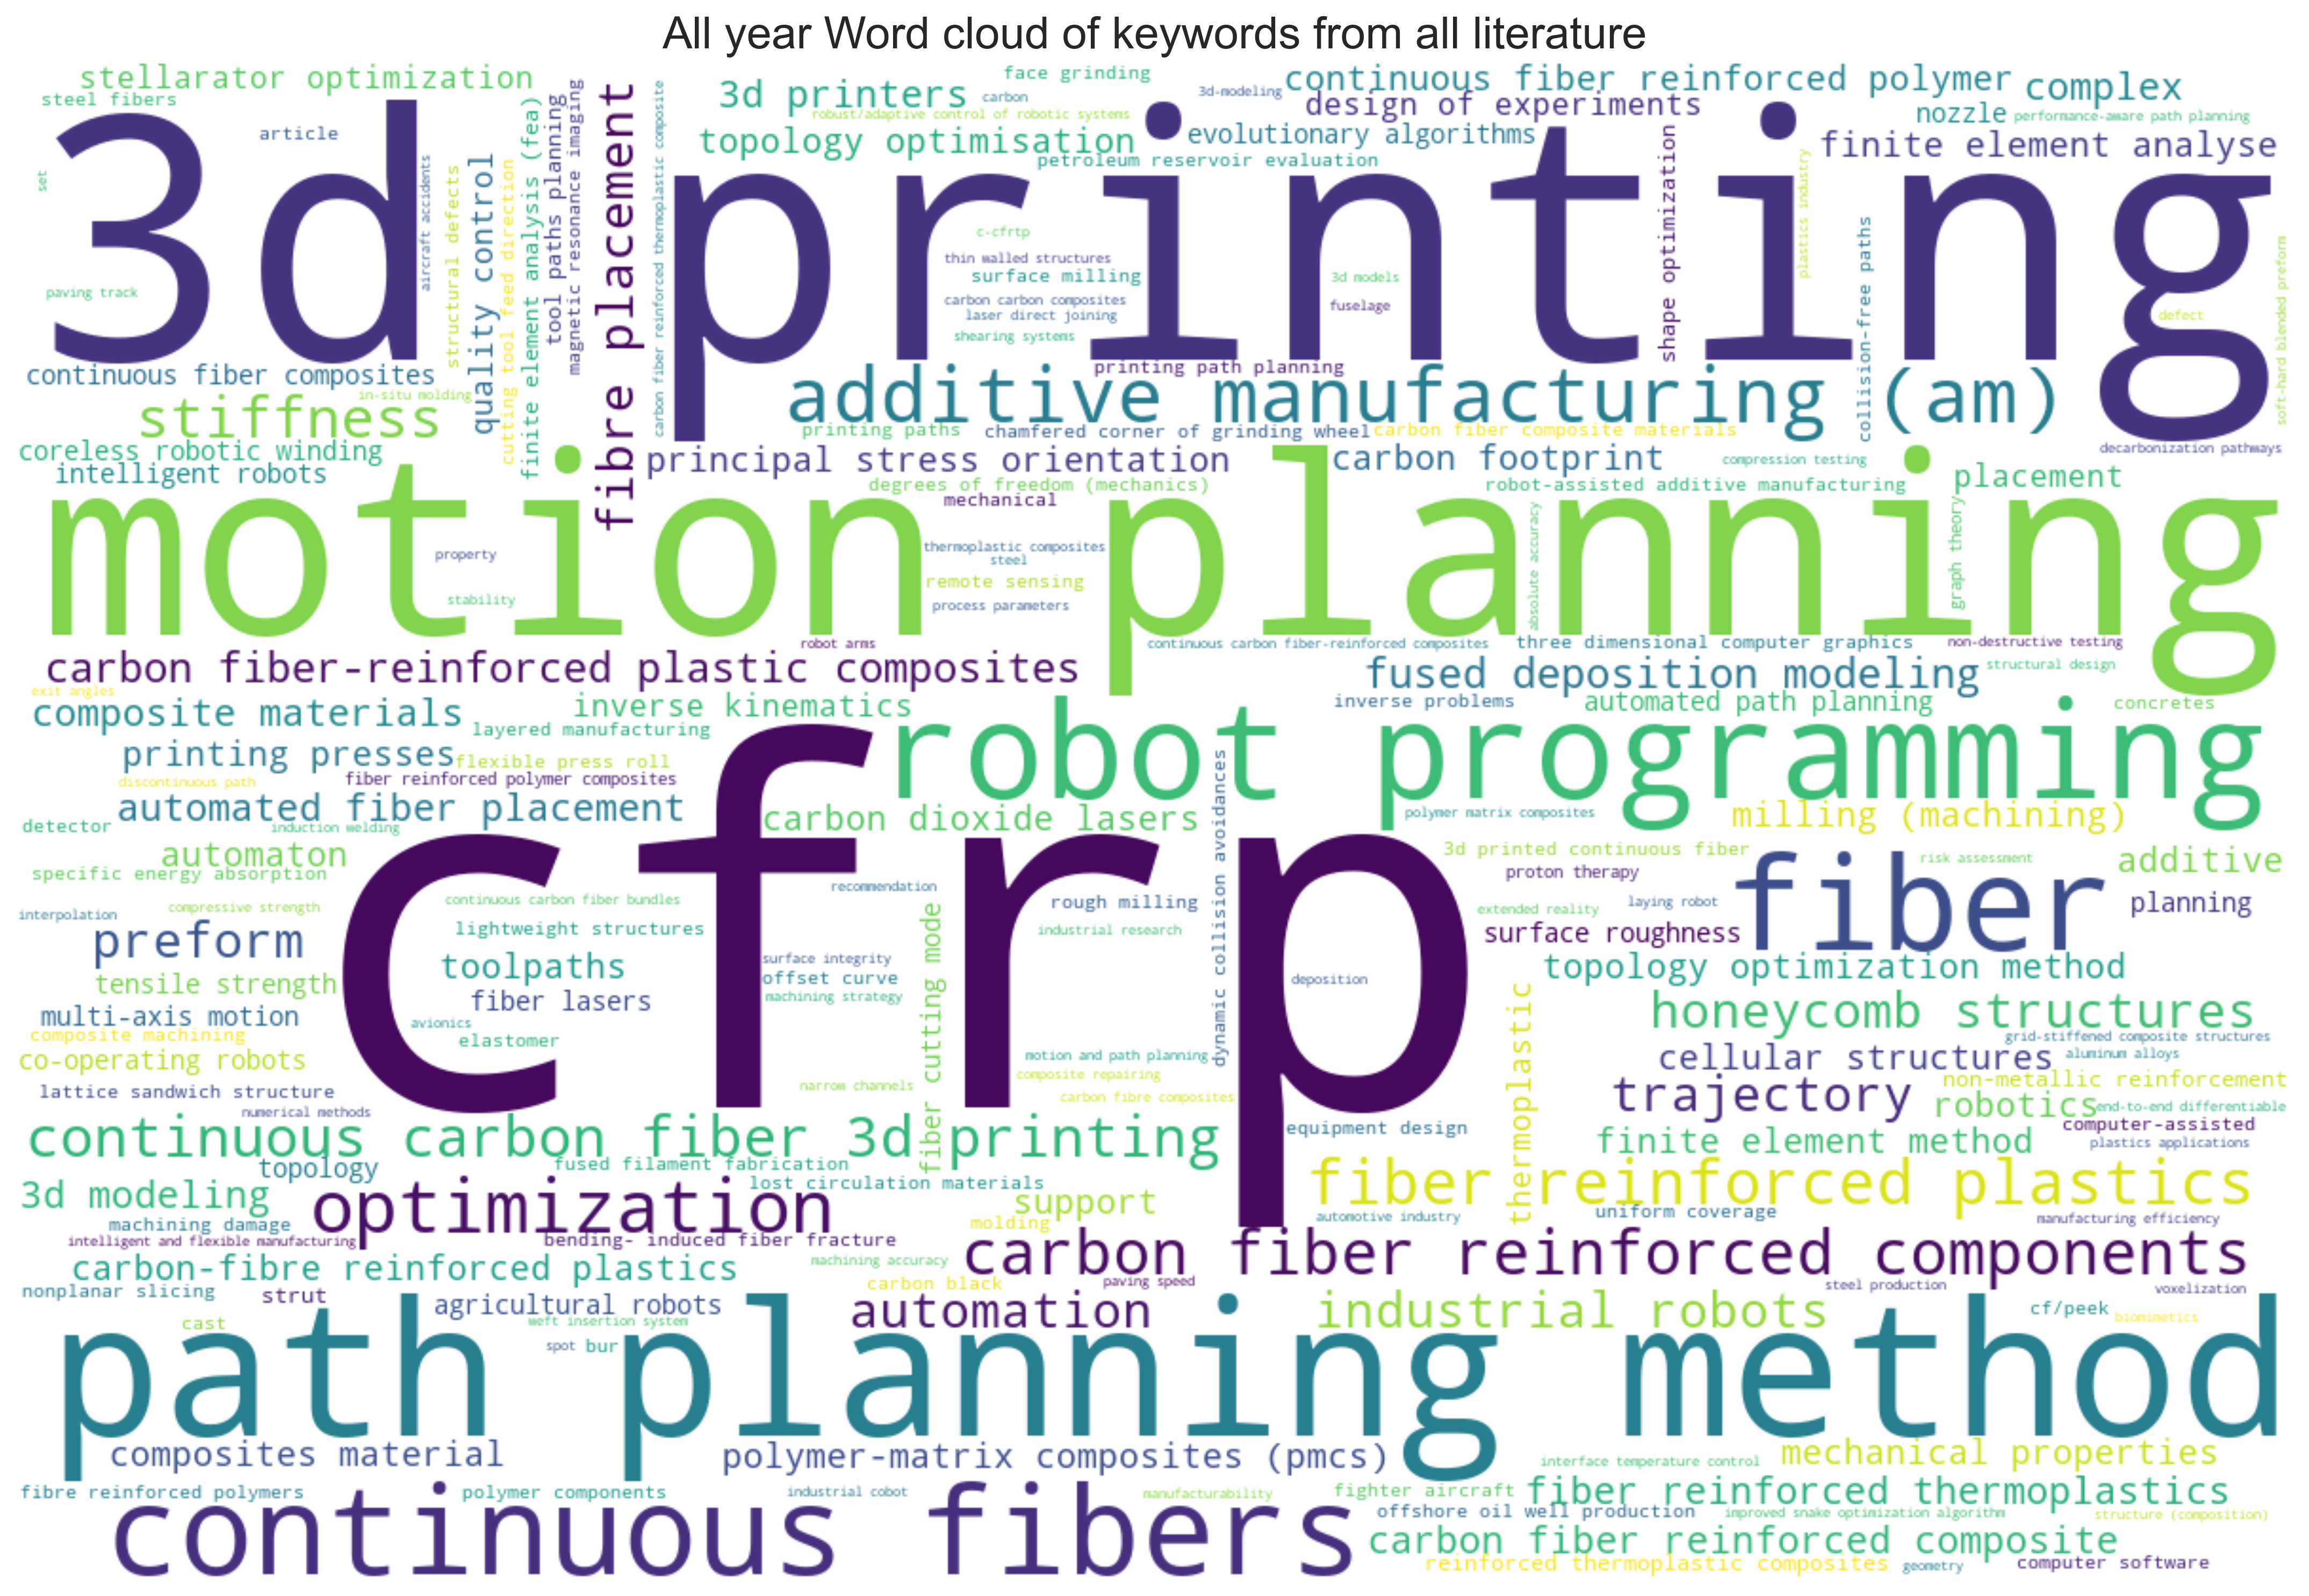

In [50]:
generate_wordcloud(filtered_df)

In [51]:
# 创建Pyecharts词云图
def generate_pyecharts_wordcloud(keywords_df):
    print("正在生成Pyecharts词云图...")
    # 确保使用所有关键词数据
    words_data = list(zip(keywords_df['关键词'].tolist(), keywords_df['频次'].tolist()))

    print(f"关键词总数: {len(keywords_df)}")
    print(f"词云数据条目: {len(words_data)}")

    # 使用pyecharts支持的参数
    wordcloud = (
        PyeWordCloud()
        .add("",
             words_data,
             word_size_range=[15, 80],
             shape="circle",
             word_gap=1,           # 减小词间距
            )
        .set_global_opts(
            title_opts=opts.TitleOpts(title=recent_year_content +" Keywords Word Cloud")  # 英文标题
        )
    )

    # 保存为HTML文件
    wordcloud.render(os.path.join(output_dir,recent_year_content+"_keywords_wordcloud.html"))
    print(f"Pyecharts词云图已保存为'keywords_wordcloud.html'，包含 {len(words_data)} 个关键词")

    return wordcloud


In [52]:
generate_pyecharts_wordcloud(filtered_df)

正在生成Pyecharts词云图...
关键词总数: 500
词云数据条目: 500
Pyecharts词云图已保存为'keywords_wordcloud.html'，包含 500 个关键词


In [53]:
# 创建柱状图
def generate_bar_chart(keywords_df, top_n=20):
    print(f"正在生成前{top_n}关键词柱状图...")
    top_keywords = keywords_df.head(top_n)

    plt.figure(figsize=(14, 8), dpi=300)
    sns.barplot(x='频次', y='关键词', data=top_keywords, palette='viridis')
    plt.title(f'{recent_year_content} Top {top_n} Keyword', fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Keyword', fontsize=14)
    plt.tight_layout()

    # 保存图表
    plt.savefig(os.path.join(output_dir,f'{recent_year_content}_top_{top_n}_keywords_barchart.png'), bbox_inches='tight')
    print(f"柱状图已保存为'top_{top_n}_keywords_barchart.png'")

    return top_keywords

正在生成前20关键词柱状图...
柱状图已保存为'top_20_keywords_barchart.png'


关键词  频次       百分比
86                                         cfrp  60  4.106776
72                                  3d printing  51  3.490760
228                             motion planning  30  2.053388
12                         path planning method  18  1.232033
239                           robot programming  15  1.026694
227                                       fiber  14  0.958248
21                            continuous fibers  13  0.889802
20                  additive manufacturing (am)  10  0.684463
80                                 optimization   9  0.616016
97           carbon fiber reinforced components   9  0.616016
1                     fiber reinforced plastics   9  0.616016
3           continuous carbon fiber 3d printing   8  0.547570
229                                   stiffness   8  0.547570
185                             fibre placement   6  0.410678
33                         honeycomb structures   6  0.410678
269                                  trajectory   6  0.410678
134                                     preform   6  0.410678
57                            industrial robots   6  0.410678
109                                  automation   6  0.410678
66   carbon fiber-reinforced plastic composites   6  0.410678

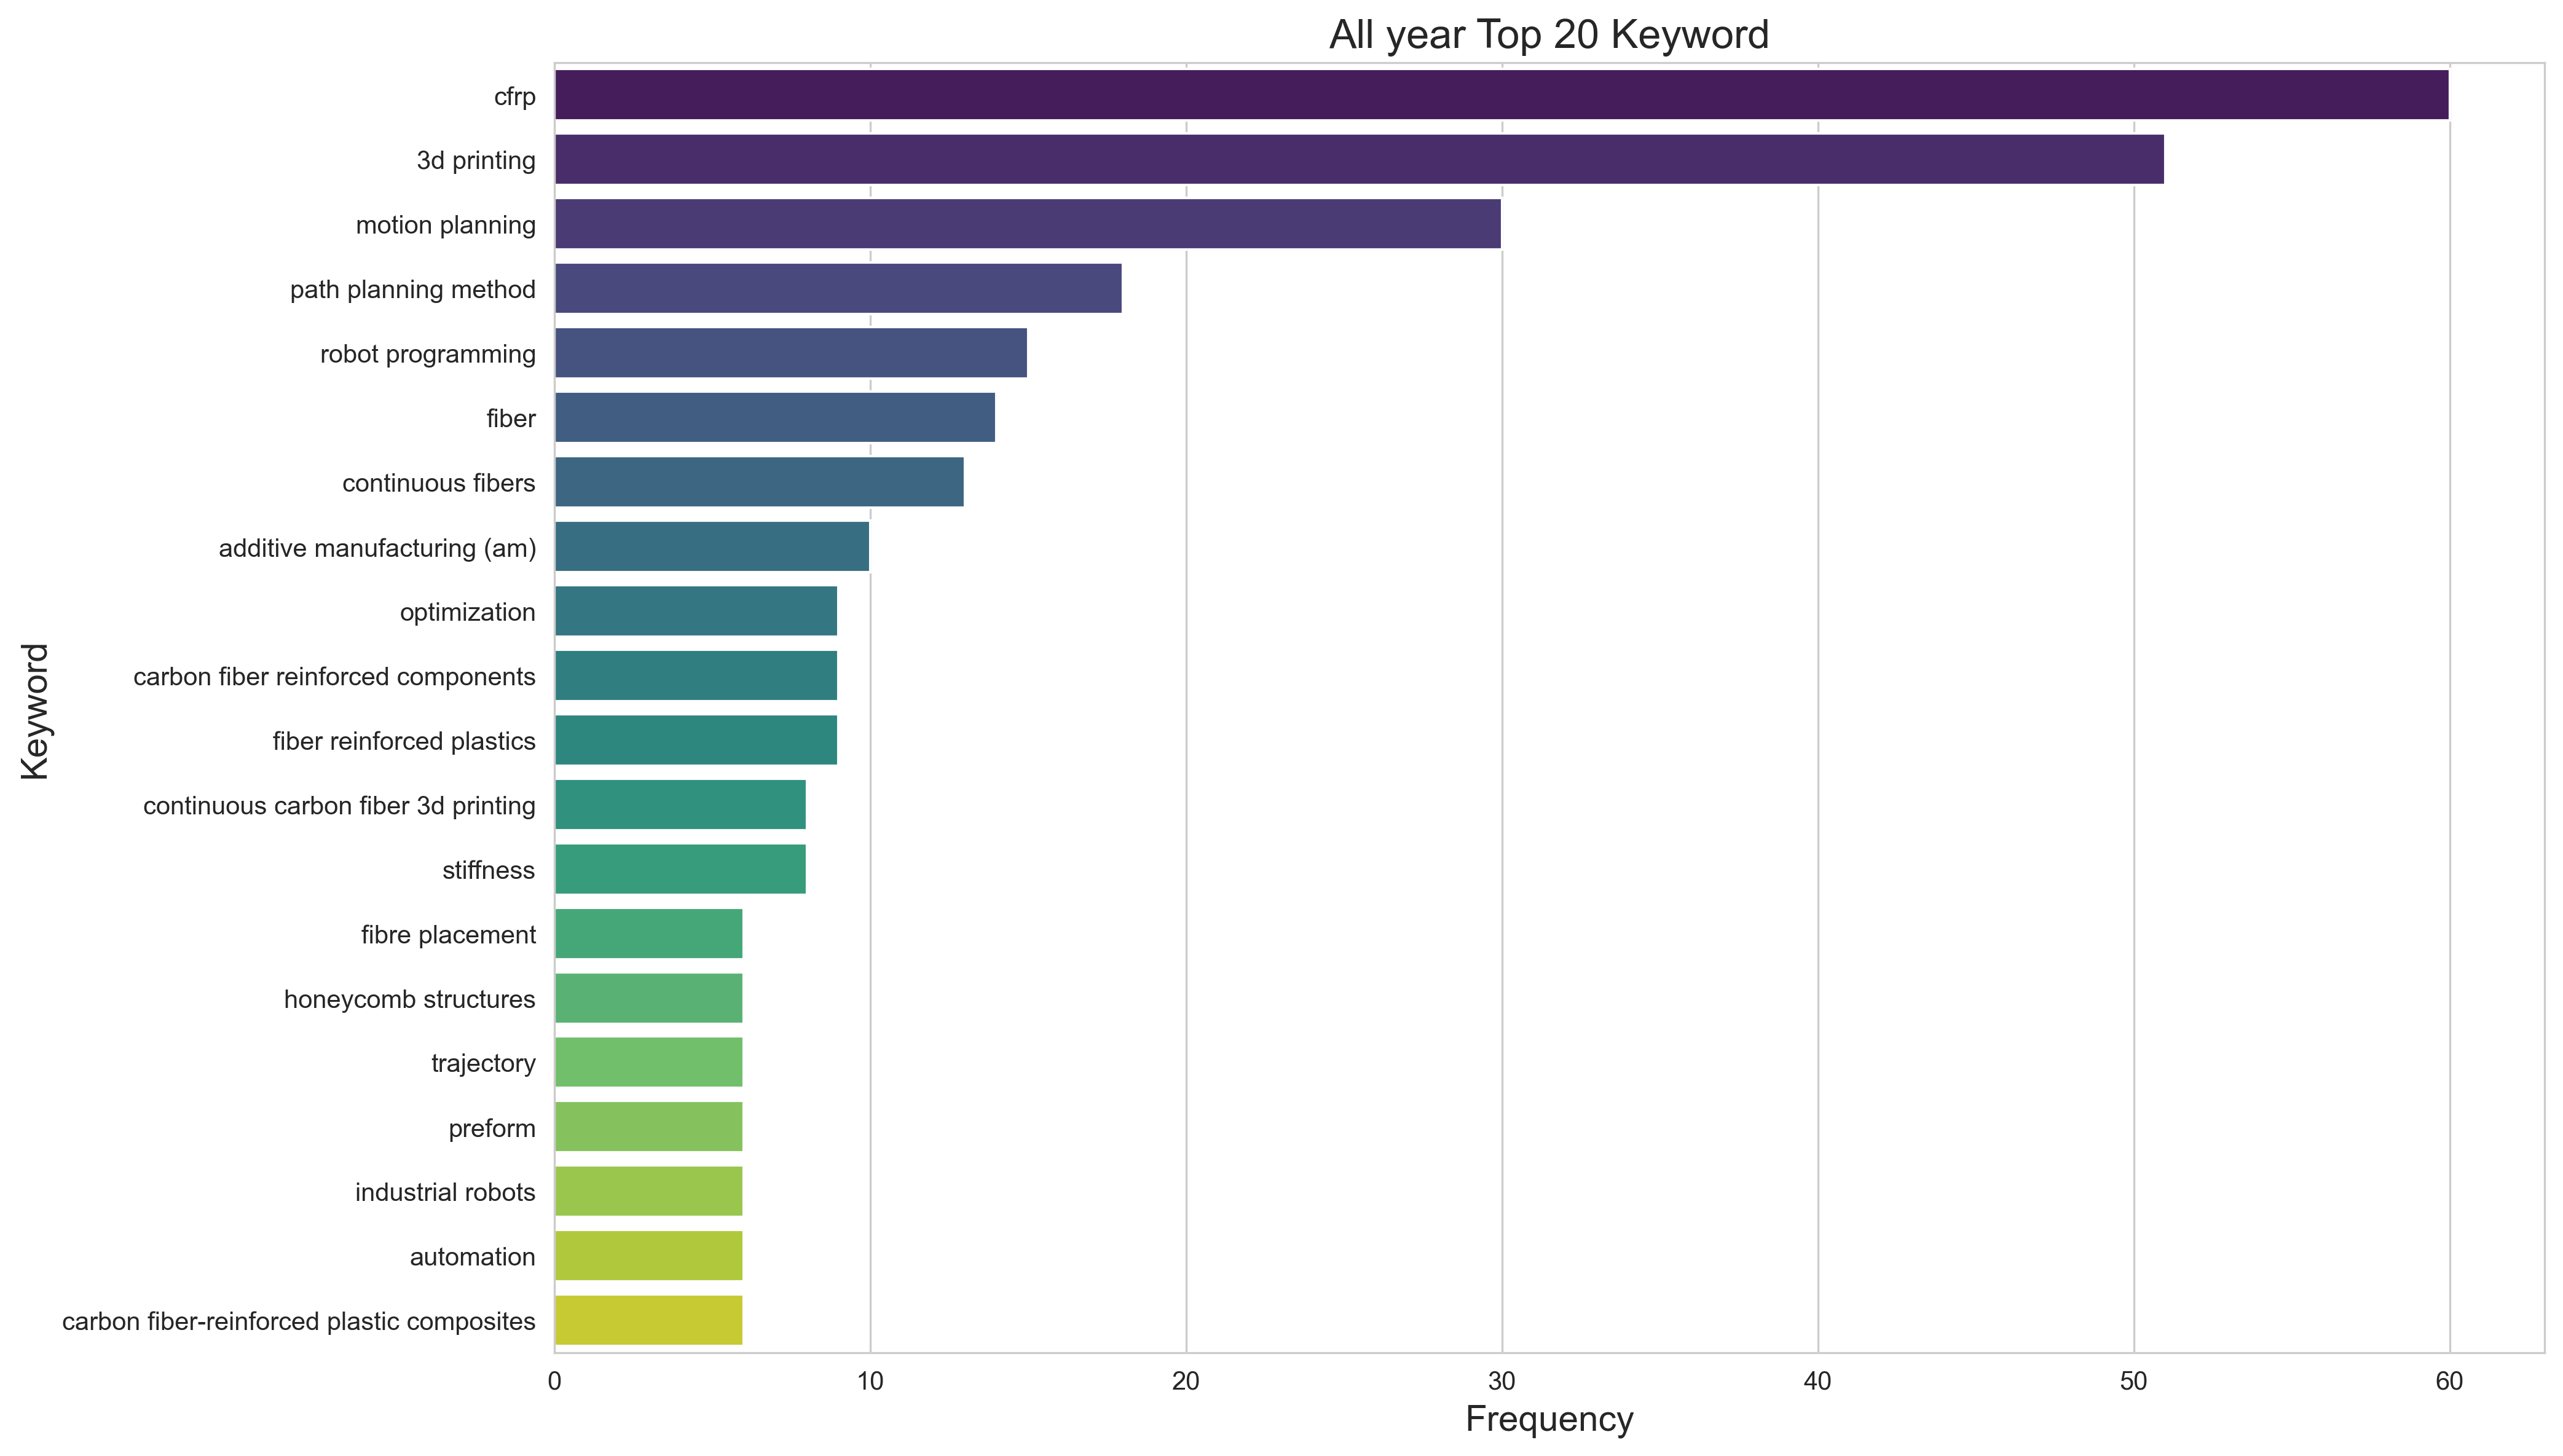

In [54]:
generate_bar_chart(filtered_df, top_n=20)

In [55]:
# 创建Pyecharts柱状图
def generate_pyecharts_bar(keywords_df, top_n=50):
    print(f"正在生成前{top_n}关键词Pyecharts柱状图...")
    top_keywords = keywords_df.head(top_n)

    bar = (
        Bar(init_opts=opts.InitOpts(theme=ThemeType.LIGHT, width="1200px", height="600px"))
        .add_xaxis(top_keywords['关键词'].tolist()[::-1])
        .add_yaxis("频次", top_keywords['频次'].tolist()[::-1])
        .reversal_axis()
        .set_series_opts(label_opts=opts.LabelOpts(position="right"))
        .set_global_opts(
            title_opts=opts.TitleOpts(title=f"{recent_year_content} Top {top_n} Keywords"),
            toolbox_opts=opts.ToolboxOpts(),
            datazoom_opts=opts.DataZoomOpts(type_="inside"),
        )
    )

    # 保存为HTML文件
    bar.render(os.path.join(output_dir, f'{recent_year_content}_top_{top_n}_keywords_barchart.html'))
    print(f"Pyecharts柱状图已保存为'top_{top_n}_keywords_barchart.html'")

    return bar

In [56]:
generate_pyecharts_bar(filtered_df, top_n=50)

正在生成前50关键词Pyecharts柱状图...
Pyecharts柱状图已保存为'top_50_keywords_barchart.html'
